Libraries

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import mean_squared_error

In [2]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

In [3]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

import warnings
warnings.filterwarnings("ignore")

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"]="3"
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Data creation


In [5]:
date_range = pd.date_range(start='1 jan 2020', end='31 dec 2023')

In [6]:
date_ranges = pd.date_range(start='1 jan 2020', end='31 march 2024')

In [7]:
def convert_date(date_str):
    date_obj = datetime.strptime(date_str, "%d-%m-%Y")
    return date_obj.strftime("%b %d, %Y")

In [8]:
def fill_na_with_mean(series):
    series = series.copy()  # To avoid modifying the original series
    n = len(series)

    for i in range(n):
        if pd.isna(series[i]):
            # Find the nearest non-NaN value to the left
            left_index = i - 1
            while left_index >= 0 and pd.isna(series[left_index]):
                left_index -= 1

            # Find the nearest non-NaN value to the right
            right_index = i + 1
            while right_index < n and pd.isna(series[right_index]):
                right_index += 1

            left_value = series[left_index] if left_index >= 0 else np.nan
            right_value = series[right_index] if right_index < n else np.nan

            # Calculate the mean of the left and right values
            if pd.notna(left_value) and pd.notna(right_value):
                series[i] = (left_value + right_value) / 2
            elif pd.notna(left_value):
                series[i] = left_value
            elif pd.notna(right_value):
                series[i] = right_value

    return series

In [9]:
df = pd.DataFrame(date_range, columns=['Date'])

In [10]:
actual_df = pd.DataFrame(date_ranges, columns=['Date'])

In [11]:
df['Date'] = df['Date'].dt.strftime('%b %d, %Y')

In [12]:
actual_df['Date'] = actual_df['Date'].dt.strftime('%b %d, %Y')

In [13]:
df['OVX Prices'] = None

In [14]:
actual_df['OVX Prices'] = None

In [15]:
actual_df.head()

,Date,OVX Prices
0,"Jan 01, 2020",None
1,"Jan 02, 2020",None
2,"Jan 03, 2020",None
3,"Jan 04, 2020",None
4,"Jan 05, 2020",None


In [16]:
df.head()

,Date,OVX Prices
0,"Jan 01, 2020",None
1,"Jan 02, 2020",None
2,"Jan 03, 2020",None
3,"Jan 04, 2020",None
4,"Jan 05, 2020",None


In [17]:
# Load the DataFrame from an Excel file
OVX = pd.read_csv('/content/India VIX Historical Data.csv')

In [18]:
actual_OVX = pd.read_csv('/content/India VIX Historical Data (2).csv')

In [19]:
actual_OVX

,Date,Price,Open,High,Low,Vol.,Change %
0,28-03-2024,12.8325,12.7025,13.1800,12.2600,NaN,1.02%
1,27-03-2024,12.7025,12.8200,13.0100,12.5325,NaN,-0.92%
2,26-03-2024,12.8200,12.2200,13.1025,12.0850,NaN,4.91%
3,22-03-2024,12.2200,12.5125,13.0475,11.8100,NaN,-2.34%
4,21-03-2024,12.5125,13.4725,13.4725,12.3425,NaN,-7.13%
...,...,...,...,...,...,...,...
1050,07-01-2020,14.6100,14.7775,14.9125,14.4625,NaN,-1.13%
1051,06-01-2020,14.7775,12.6950,15.0950,12.6950,NaN,16.40%
1052,03-01-2020,12.6950,11.4900,12.9400,10.6850,NaN,10.49%
1053,02-01-2020,11.4900,11.5975,11.7000,10.7300,NaN,-0.93%


In [20]:
OVX.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,29-12-2023,14.5025,15.1400,15.4275,14.3725,NaN,-4.21%
1,28-12-2023,15.1400,15.5575,16.4700,14.9625,NaN,-2.68%
2,27-12-2023,15.5575,14.6775,15.7325,14.4700,NaN,6.00%
3,26-12-2023,14.6775,13.7075,14.9500,13.7075,NaN,7.08%
4,22-12-2023,13.7075,13.7575,13.9875,12.2250,NaN,-0.36%


In [21]:
OVX['Date'] = OVX['Date'].apply(convert_date)

In [22]:
actual_OVX['Date'] = actual_OVX['Date'].apply(convert_date)

In [23]:
OVX_map = OVX.set_index(OVX.columns[0])[OVX.columns[1]].to_dict()
OVX_map

{'Dec 29, 2023': 14.5025,
 'Dec 28, 2023': 15.14,
 'Dec 27, 2023': 15.5575,
 'Dec 26, 2023': 14.6775,
 'Dec 22, 2023': 13.7075,
 'Dec 21, 2023': 13.7575,
 'Dec 20, 2023': 14.45,
 'Dec 19, 2023': 13.8675,
 'Dec 18, 2023': 13.9,
 'Dec 15, 2023': 13.1275,
 'Dec 14, 2023': 12.32,
 'Dec 13, 2023': 12.065,
 'Dec 12, 2023': 12.7125,
 'Dec 11, 2023': 12.7575,
 'Dec 08, 2023': 12.47,
 'Dec 07, 2023': 12.6725,
 'Dec 06, 2023': 13.74,
 'Dec 05, 2023': 13.4575,
 'Dec 04, 2023': 12.9925,
 'Dec 01, 2023': 12.3825,
 'Nov 30, 2023': 12.69,
 'Nov 29, 2023': 12.7075,
 'Nov 28, 2023': 12.175,
 'Nov 24, 2023': 11.33,
 'Nov 23, 2023': 11.315,
 'Nov 22, 2023': 11.865,
 'Nov 21, 2023': 12.2325,
 'Nov 20, 2023': 12.1475,
 'Nov 17, 2023': 11.8275,
 'Nov 16, 2023': 11.6475,
 'Nov 15, 2023': 11.135,
 'Nov 13, 2023': 11.1875,
 'Nov 12, 2023': 11.3475,
 'Nov 10, 2023': 11.1075,
 'Nov 09, 2023': 10.9825,
 'Nov 08, 2023': 11.0375,
 'Nov 07, 2023': 11.1925,
 'Nov 06, 2023': 11.105,
 'Nov 03, 2023': 10.8825,
 'Nov 02,

In [24]:
actual_map = actual_OVX.set_index(actual_OVX.columns[0])[actual_OVX.columns[1]].to_dict()
actual_map

{'Mar 28, 2024': 12.8325,
 'Mar 27, 2024': 12.7025,
 'Mar 26, 2024': 12.82,
 'Mar 22, 2024': 12.22,
 'Mar 21, 2024': 12.5125,
 'Mar 20, 2024': 13.4725,
 'Mar 19, 2024': 14.1125,
 'Mar 18, 2024': 13.895,
 'Mar 15, 2024': 13.69,
 'Mar 14, 2024': 13.6225,
 'Mar 13, 2024': 14.4325,
 'Mar 12, 2024': 13.6375,
 'Mar 11, 2024': 13.995,
 'Mar 07, 2024': 13.6125,
 'Mar 06, 2024': 14.295,
 'Mar 05, 2024': 14.38,
 'Mar 04, 2024': 14.9225,
 'Mar 02, 2024': 14.9925,
 'Mar 01, 2024': 15.235,
 'Feb 29, 2024': 15.5725,
 'Feb 28, 2024': 16.33,
 'Feb 27, 2024': 15.7275,
 'Feb 26, 2024': 15.6,
 'Feb 23, 2024': 14.9725,
 'Feb 22, 2024': 15.1975,
 'Feb 21, 2024': 15.9275,
 'Feb 20, 2024': 16.0725,
 'Feb 19, 2024': 16.0175,
 'Feb 16, 2024': 15.2225,
 'Feb 15, 2024': 15.225,
 'Feb 14, 2024': 15.435,
 'Feb 13, 2024': 15.8075,
 'Feb 12, 2024': 16.0625,
 'Feb 09, 2024': 15.4475,
 'Feb 08, 2024': 15.8275,
 'Feb 07, 2024': 15.505,
 'Feb 06, 2024': 15.785,
 'Feb 05, 2024': 15.6175,
 'Feb 02, 2024': 14.6975,
 'Feb 0

In [25]:
# Iterate over each row in df
for index, row in df.iterrows():

    date = row['Date']
    # print(date)
    price = OVX_map.get(date)
    # print(price)
    df.at[index, 'OVX Prices'] = price

In [26]:
# Iterate over each row in df
for index, row in actual_df.iterrows():

    date = row['Date']
    print(date)
    price = actual_map.get(date)
    print(price)
    actual_df.at[index, 'OVX Prices'] = price

Jan 01, 2020
11.5975
Jan 02, 2020
11.49
Jan 03, 2020
12.695
Jan 04, 2020
None
Jan 05, 2020
None
Jan 06, 2020
14.7775
Jan 07, 2020
14.61
Jan 08, 2020
15.64
Jan 09, 2020
13.9975
Jan 10, 2020
14.0775
Jan 11, 2020
None
Jan 12, 2020
None
Jan 13, 2020
14.275
Jan 14, 2020
13.9125
Jan 15, 2020
14.12
Jan 16, 2020
14.1825
Jan 17, 2020
14.1275
Jan 18, 2020
None
Jan 19, 2020
None
Jan 20, 2020
15.41
Jan 21, 2020
15.8625
Jan 22, 2020
16.36
Jan 23, 2020
15.855
Jan 24, 2020
15.56
Jan 25, 2020
None
Jan 26, 2020
None
Jan 27, 2020
17.175
Jan 28, 2020
17.2975
Jan 29, 2020
16.4975
Jan 30, 2020
16.7975
Jan 31, 2020
17.3675
Feb 01, 2020
16.835
Feb 02, 2020
None
Feb 03, 2020
15.7825
Feb 04, 2020
14.38
Feb 05, 2020
14.1725
Feb 06, 2020
13.78
Feb 07, 2020
13.7475
Feb 08, 2020
None
Feb 09, 2020
None
Feb 10, 2020
14.21
Feb 11, 2020
13.88
Feb 12, 2020
13.6225
Feb 13, 2020
13.37
Feb 14, 2020
13.615
Feb 15, 2020
None
Feb 16, 2020
None
Feb 17, 2020
14.415
Feb 18, 2020
14.51
Feb 19, 2020
14.0225
Feb 20, 2020
13.7
Feb 

In [27]:
df

,Date,OVX Prices
0,"Jan 01, 2020",11.5975
1,"Jan 02, 2020",11.49
2,"Jan 03, 2020",12.695
3,"Jan 04, 2020",None
4,"Jan 05, 2020",None
...,...,...
1456,"Dec 27, 2023",15.5575
1457,"Dec 28, 2023",15.14
1458,"Dec 29, 2023",14.5025
1459,"Dec 30, 2023",None


In [28]:
actual_df

,Date,OVX Prices
0,"Jan 01, 2020",11.5975
1,"Jan 02, 2020",11.49
2,"Jan 03, 2020",12.695
3,"Jan 04, 2020",None
4,"Jan 05, 2020",None
...,...,...
1547,"Mar 27, 2024",12.7025
1548,"Mar 28, 2024",12.8325
1549,"Mar 29, 2024",None
1550,"Mar 30, 2024",None


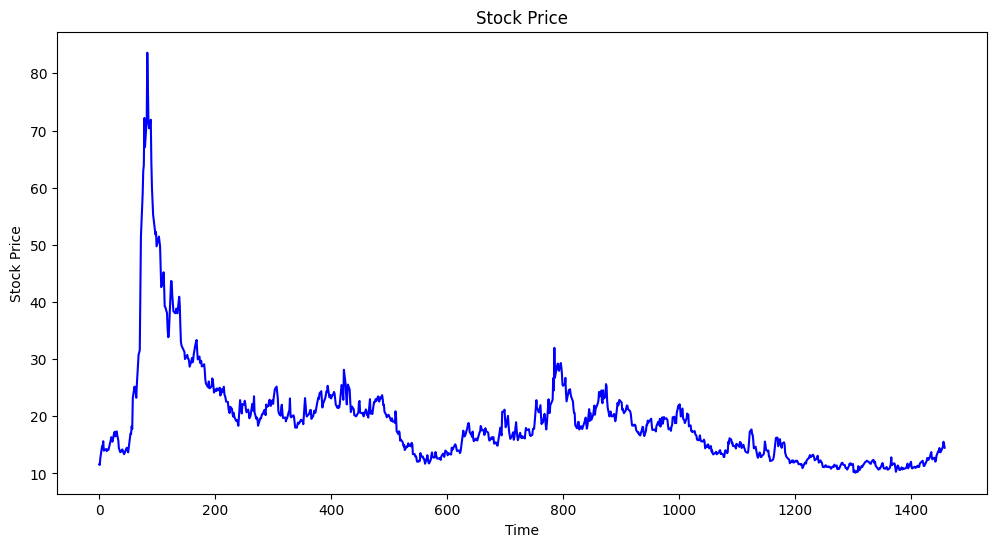

In [29]:
df.dropna(inplace=True)

plt.figure(figsize=(12,6))
plt.plot(df["OVX Prices"],color="blue");
plt.ylabel("Stock Price")
plt.title("Stock Price")
plt.xlabel("Time")
plt.show()

In [30]:
df['OVX Prices'] = pd.to_numeric(df['OVX Prices'], errors='coerce')

# Step 2: Fill NaN values with the mean of the column
df['OVX Prices'].fillna(df['OVX Prices'].mean(), inplace=True)

In [31]:
# actual_df['OVX Prices'] = fill_na_with_mean(actual_df['OVX Prices'].values)

In [32]:
df["Date"]=pd.to_datetime(df["Date"])

In [33]:
actual_df["Date"]=pd.to_datetime(actual_df["Date"])

In [34]:
df

,Date,OVX Prices
0,2020-01-01,11.5975
1,2020-01-02,11.4900
2,2020-01-03,12.6950
5,2020-01-06,14.7775
6,2020-01-07,14.6100
...,...,...
1451,2023-12-22,13.7075
1455,2023-12-26,14.6775
1456,2023-12-27,15.5575
1457,2023-12-28,15.1400


In [35]:
df.index=df["Date"]
df

,Date,OVX Prices
Date,,
2020-01-01,2020-01-01,11.5975
2020-01-02,2020-01-02,11.4900
2020-01-03,2020-01-03,12.6950
2020-01-06,2020-01-06,14.7775
2020-01-07,2020-01-07,14.6100
...,...,...
2023-12-22,2023-12-22,13.7075
2023-12-26,2023-12-26,14.6775
2023-12-27,2023-12-27,15.5575


In [36]:
actual_df.index = actual_df['Date']
actual_df

,Date,OVX Prices
Date,,
2020-01-01,2020-01-01,11.5975
2020-01-02,2020-01-02,11.49
2020-01-03,2020-01-03,12.695
2020-01-04,2020-01-04,None
2020-01-05,2020-01-05,None
...,...,...
2024-03-27,2024-03-27,12.7025
2024-03-28,2024-03-28,12.8325
2024-03-29,2024-03-29,None


In [37]:
df.drop("Date",axis=1,inplace=True)

In [38]:
orig_df = df

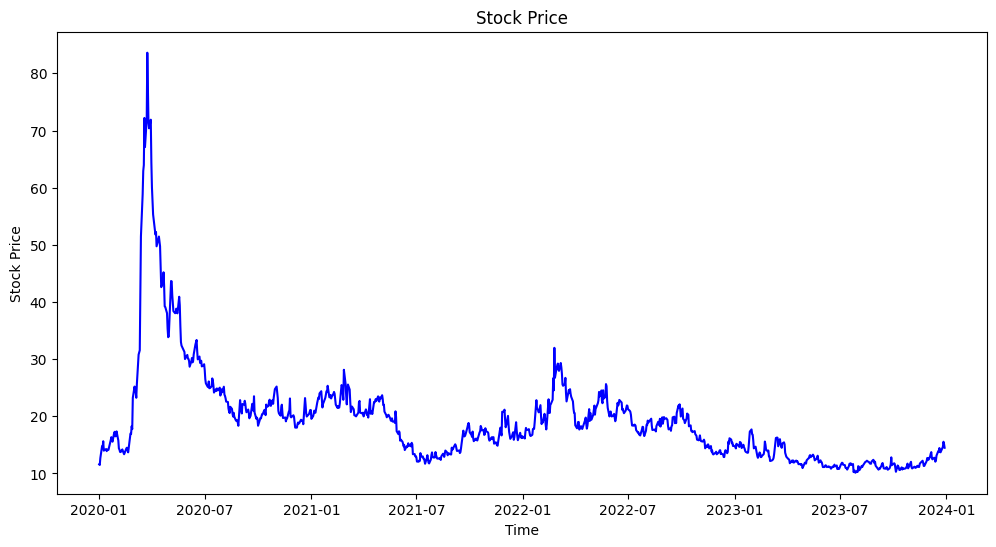

In [39]:
plt.figure(figsize=(12,6))
plt.plot(df["OVX Prices"],color="blue");
plt.ylabel("Stock Price")
plt.title("Stock Price")
plt.xlabel("Time")
plt.show()

In [40]:
data = df.values

In [41]:
data

array([[11.5975],
       [11.49  ],
       [12.695 ],
       [14.7775],
       [14.61  ],
       [15.64  ],
       [13.9975],
       [14.0775],
       [14.275 ],
       [13.9125],
       [14.12  ],
       [14.1825],
       [14.1275],
       [15.41  ],
       [15.8625],
       [16.36  ],
       [15.855 ],
       [15.56  ],
       [17.175 ],
       [17.2975],
       [16.4975],
       [16.7975],
       [17.3675],
       [16.835 ],
       [15.7825],
       [14.38  ],
       [14.1725],
       [13.78  ],
       [13.7475],
       [14.21  ],
       [13.88  ],
       [13.6225],
       [13.37  ],
       [13.615 ],
       [14.415 ],
       [14.51  ],
       [14.0225],
       [13.7   ],
       [16.9975],
       [16.8975],
       [18.26  ],
       [17.765 ],
       [23.235 ],
       [25.2025],
       [24.5425],
       [24.225 ],
       [23.2475],
       [25.6425],
       [30.8   ],
       [31.555 ],
       [41.1625],
       [51.4725],
       [58.875 ],
       [62.925 ],
       [63.955 ],
       [72

In [42]:
data = data.astype("float32")

Preprocessing


In [43]:
def split_data(dataframe,test_size):
    pos=int(round(len(dataframe)*(1-test_size)))
    train=dataframe[:pos]
    test=dataframe[pos:]
    return train,test,pos

In [44]:
train,test,pos=split_data(data,0.20)

In [45]:
print(train.shape, test.shape)

(794, 1) (199, 1)


In [46]:
from sklearn.preprocessing import MinMaxScaler
scaler_train=MinMaxScaler(feature_range=(0,1))
train=scaler_train.fit_transform(train)

In [47]:
scaler_test=MinMaxScaler(feature_range=(0,1))
test=scaler_test.fit_transform(test)

In [48]:
train[0:5]

array([[0.00149062],
       [0.        ],
       [0.01670884],
       [0.04558533],
       [0.04326274]], dtype=float32)

In [49]:
def create_features(data,lookback):
    X,Y=[],[]
    for i in range(lookback,len(data)):
        X.append(data[i-lookback:i,0])
        Y.append(data[i,0])
    return np.array(X),np.array(Y)

In [50]:
lookback= 55

In [51]:
X_train,y_train=create_features(train,lookback)

In [52]:
X_test,y_test=create_features(test,lookback)

In [53]:
X_train=np.reshape(X_train,(X_train.shape[0],1,X_train.shape[1]))

In [54]:
X_test=np.reshape(X_test,(X_test.shape[0],1,X_test.shape[1]))

In [55]:
y_train=y_train.reshape(-1,1)

In [56]:
y_test=y_test.reshape(-1,1)

In [57]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(739, 1, 55) (739, 1) (144, 1, 55) (144, 1)


Modelling


In [58]:
model=Sequential()
model.add(LSTM(units=50,
              activation="relu",
              input_shape=(X_train.shape[1],lookback)))
model.add(Dropout(0.2))
model.add(Dense(1))

In [59]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                21200     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 21251 (83.01 KB)
Trainable params: 21251 (83.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [60]:
model.compile(loss="mean_squared_error",optimizer="adam")

In [61]:
callbacks=[EarlyStopping(monitor="val_loss",patience=3,verbose=1,mode="min"),
          ModelCheckpoint(filepath="mymodel.h5",monitor="val_loss",mode="min",
                         save_best_only=True,save_weights_only=False,verbose=1)]

In [62]:
history = model.fit(x=X_train,
                    y=y_train,
                    epochs=100,
                    batch_size=20,
                    validation_data=(X_test,y_test),
                    callbacks=callbacks,
                    shuffle=False)

Epoch 1/100
21/37 [================>.............] - ETA: 0s - loss: 0.0389  
Epoch 1: val_loss improved from inf to 0.03083, saving model to mymodel.h5
37/37 [==============================] - 2s 14ms/step - loss: 0.0230 - val_loss: 0.0308
Epoch 2/100
20/37 [===============>..............] - ETA: 0s - loss: 0.0197
Epoch 2: val_loss improved from 0.03083 to 0.02805, saving model to mymodel.h5
37/37 [==============================] - 0s 4ms/step - loss: 0.0115 - val_loss: 0.0280
Epoch 3/100
37/37 [==============================] - ETA: 0s - loss: 0.0085
Epoch 3: val_loss improved from 0.02805 to 0.02204, saving model to mymodel.h5
37/37 [==============================] - 0s 5ms/step - loss: 0.0085 - val_loss: 0.0220
Epoch 4/100
31/37 [========================>.....] - ETA: 0s - loss: 0.0082
Epoch 4: val_loss improved from 0.02204 to 0.02003, saving model to mymodel.h5
37/37 [==============================] - 0s 7ms/step - loss: 0.0071 - val_loss: 0.0200
Epoch 5/100
30/37 [==============

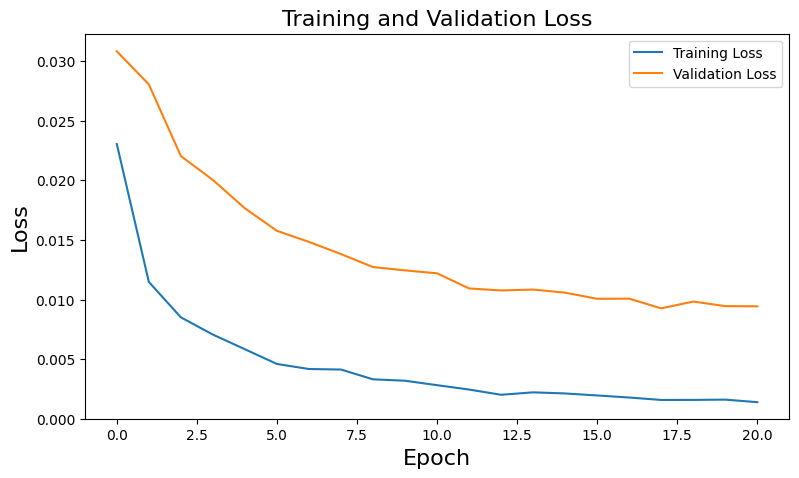

In [63]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,2)
plt.plot(history.history["loss"],label="Training Loss")
plt.plot(history.history["val_loss"],label="Validation Loss")
plt.legend(loc="upper right")
plt.xlabel("Epoch",fontsize=16)
plt.ylabel("Loss",fontsize=16)
plt.ylim([0,max(plt.ylim())])
plt.title("Training and Validation Loss",fontsize=16)
plt.show()

Evaluation


In [64]:
loss=model.evaluate(X_test,y_test,batch_size=20)

8/8 [==============================] - 0s 2ms/step - loss: 0.0094


In [65]:
print("\nTest loss:%.1f%%"%(100.0*loss))


Test loss:0.9%


In [66]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

5/5 [==============================] - 0s 5ms/step


In [67]:
train_predict=scaler_train.inverse_transform(train_predict)
test_predict=scaler_test.inverse_transform(test_predict)

In [68]:
y_train=scaler_train.inverse_transform(y_train)
y_test=scaler_test.inverse_transform(y_test)

RMSE values


In [69]:
train_rmse=np.sqrt(mean_squared_error(y_train,train_predict))

In [70]:
test_rmse=np.sqrt(mean_squared_error(y_test,test_predict,))

In [71]:
print(f"Train RMSE:{train_rmse}")
print(f"Test RMSE:{test_rmse}")

Train RMSE:2.2538504600524902
Test RMSE:0.5982199907302856


In [72]:
train_prediction_data=orig_df[lookback:pos]

In [73]:
train_prediction_data

,OVX Prices
Date,
2020-03-19,72.1975
2020-03-20,67.1000
2020-03-23,71.9850
2020-03-24,83.6075
2020-03-25,77.6250
...,...
2023-03-02,12.9700
2023-03-03,12.1800
2023-03-06,12.2675


In [74]:
train_prediction_data["Predicted"]=train_predict

In [75]:
train_prediction_data.head()

,OVX Prices,Predicted
Date,,
2020-03-19,72.1975,45.824970
2020-03-20,67.1000,51.613659
2020-03-23,71.9850,55.845566
2020-03-24,83.6075,60.263119
2020-03-25,77.6250,66.478874


In [76]:
test_prediction_data=orig_df[pos+lookback:]

In [77]:
test_prediction_data["Predicted"]=test_predict

In [78]:
test_prediction_data.head()

,OVX Prices,Predicted
Date,,
2023-06-02,11.1250,12.043263
2023-06-05,11.1375,11.865878
2023-06-06,11.3800,11.640331
2023-06-07,11.4425,11.702196
2023-06-08,11.2575,11.519622


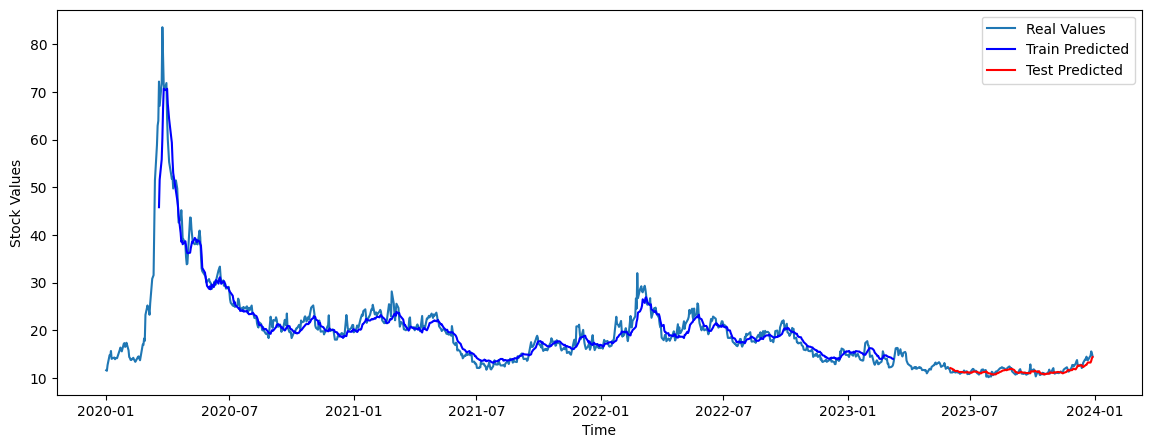

In [79]:
plt.figure(figsize=(14,5))
plt.plot(df,label="Real Values")
plt.plot(train_prediction_data["Predicted"],color="blue",label="Train Predicted")
plt.plot(test_prediction_data["Predicted"],color="red",label="Test Predicted")
plt.xlabel("Time")
plt.ylabel("Stock Values")
plt.legend()
plt.show()

In [80]:
data_close = data.reshape(-1, 1)

# Scale the data
scaled_data = scaler_test.fit_transform(data_close)

# Define the lookback period
lookback = 55 # Adjusting the lookback period as per the new requirement

# Ensure we have enough data to cover the lookback period
if len(scaled_data) < lookback:
    raise ValueError("Not enough data to cover the lookback period")

# Extract the last sequence
temp_input = scaled_data[-lookback:]

# Initialize the necessary variables
lst_output = []
n_steps = lookback
i = 0

In [81]:
temp_input.shape

(55, 1)

In [82]:
# Implement the loop-based prediction
# while i < 91:  # Predicting for 31 days in January 2024
if len(temp_input) > lookback:
    # Convert temp_input to a NumPy array and extract the relevant portion
    temp_array = np.array(temp_input[1:])
    x_input = temp_array.reshape((1, 1, n_steps))

print("Shape of x_input before prediction:", x_input.shape)  # Check shape before prediction

yhat = model.predict(x_input, verbose=0)

Shape of x_input before prediction: (1, 1, 55)


In [83]:
while i < 91:  # Predicting for 91 days in January 2024
    x_input = temp_input.reshape((1, 1, n_steps))

    # print("Shape of x_input before prediction:", x_input.shape)  # Check shape before prediction

    yhat = model.predict(x_input, verbose=0)

    # Append the prediction to temp_input and remove the oldest entry
    temp_input = np.append(temp_input, yhat[0, 0])
    temp_input = temp_input[-n_steps:]  # Ensure temp_input only contains the latest n_steps values
    temp_input = temp_input.reshape(-1, 1)  # Reshape back to 2D array for consistency

    # print("Shape of temp_input after appending prediction:", temp_input.shape)  # Check shape after appending

    lst_output.append(yhat[0, 0])  # Collect the output predictions
    i += 1


In [84]:
# Inverse transform the predictions to get actual prices
predicted_prices = scaler_test.inverse_transform(np.array(lst_output).reshape(-1, 1))

# Create a DataFrame to hold the predictions
predicted_dates = pd.date_range(start='2024-01-01', periods=91, freq='D')
predicted_df = pd.DataFrame(data=predicted_prices, index=predicted_dates, columns=['Predicted Close'])

# Output the predicted DataFrame
predicted_df

,Predicted Close
2024-01-01,14.860643
2024-01-02,14.893686
2024-01-03,15.033364
2024-01-04,15.035132
2024-01-05,15.105822
...,...
2024-03-27,16.666082
2024-03-28,16.671925
2024-03-29,16.669868
2024-03-30,16.669306


In [85]:
appended_df = pd.concat([df, predicted_df], axis=0)
appended_df

,OVX Prices,Predicted Close
2020-01-01,11.5975,NaN
2020-01-02,11.4900,NaN
2020-01-03,12.6950,NaN
2020-01-06,14.7775,NaN
2020-01-07,14.6100,NaN
...,...,...
2024-03-27,NaN,16.666082
2024-03-28,NaN,16.671925
2024-03-29,NaN,16.669868
2024-03-30,NaN,16.669306


In [86]:
# Filter for January 2024
january_2024_df = appended_df['2024-01-01':'2024-03-31']

# Assign predicted values to OVX Prices
appended_df.loc['2024-01-01':'2024-03-31', 'OVX Prices'] = january_2024_df['Predicted Close']

In [87]:
appended_df

,OVX Prices,Predicted Close
2020-01-01,11.597500,NaN
2020-01-02,11.490000,NaN
2020-01-03,12.695000,NaN
2020-01-06,14.777500,NaN
2020-01-07,14.610000,NaN
...,...,...
2024-03-27,16.666082,16.666082
2024-03-28,16.671925,16.671925
2024-03-29,16.669868,16.669868
2024-03-30,16.669306,16.669306


In [88]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

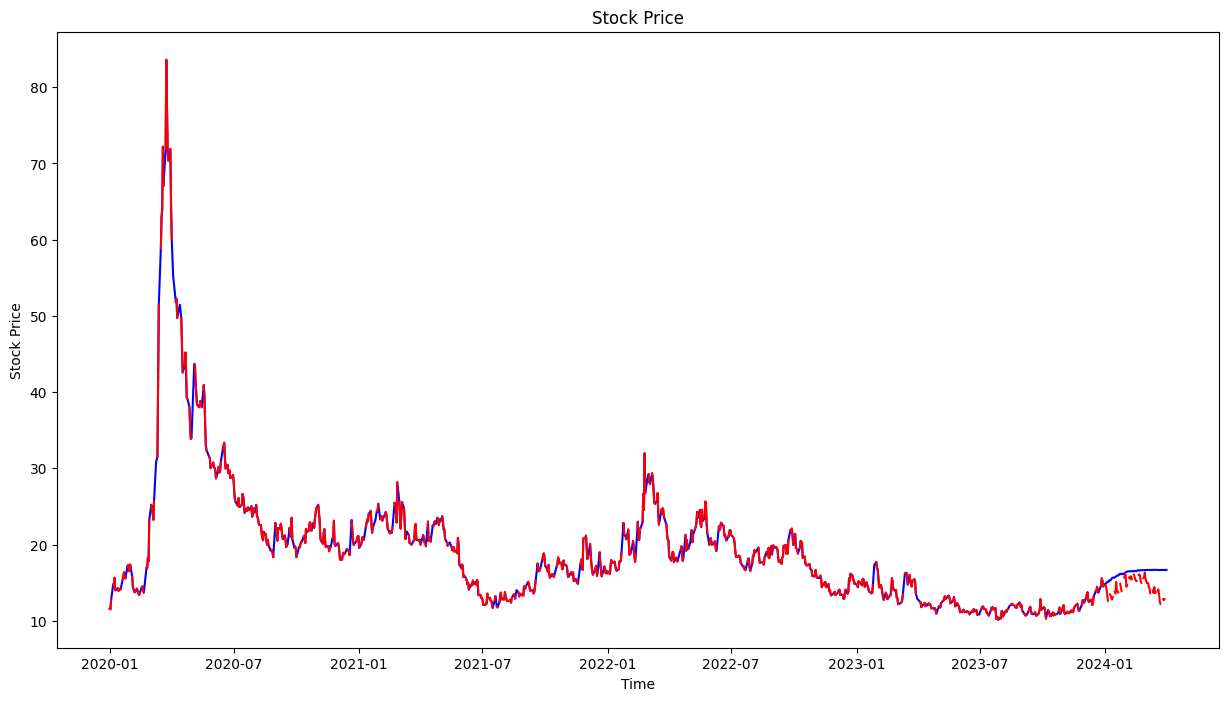

In [89]:
plt.figure(figsize=(15,8))
plt.plot(appended_df["OVX Prices"],color="blue");
plt.plot(actual_df["OVX Prices"],color="red");
plt.ylabel("Stock Price")
plt.title("Stock Price")
plt.xlabel("Time")
plt.show()

In [90]:
# appended_df.to_csv('appended_data.csv')
# from google.colab import files
# # files.download('appended_data.csv')